In [13]:
# 1. install kaggle package
!pip install kaggle

# 2. move kaggle.json (upload via Colab UI or mount from Drive)
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/   # ✅ هنا أضفنا المسار الجديد
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download dataset (use the dataset slug)
!kaggle datasets download -d rishidamarla/heart-disease-prediction
# 4. Unzip the downloaded file into a dataset folder
!unzip /content/heart-disease-prediction.zip -d /content/dataset


Dataset URL: https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction
License(s): CC0-1.0
  0% 0.00/3.41k [00:00<?, ?B/s]
100% 3.41k/3.41k [00:00<00:00, 14.3MB/s]
Archive:  /content/heart-disease-prediction.zip
  inflating: /content/dataset/Heart_Disease_Prediction.csv  


In [14]:
!pip install keras_tuner

Trial 20 Complete [00h 00m 05s]
val_accuracy: 0.7954545617103577

Best val_accuracy So Far: 0.8636363744735718
Total elapsed time: 00h 02m 01s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


أفضل معاملات Hyperparameters: {'num_layers': 5, 'units_0': 160, 'activation_0': 'elu', 'dropout_0': 0.3, 'units_1': 32, 'activation_1': 'relu', 'dropout_1': 0.2, 'optimizer': 'adam', 'units_2': 96, 'activation_2': 'elu', 'dropout_2': 0.5, 'units_3': 160, 'activation_3': 'relu', 'dropout_3': 0.0, 'units_4': 64, 'activation_4': 'relu', 'dropout_4': 0.3}


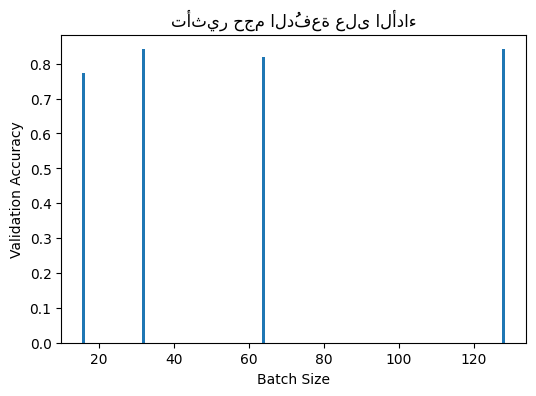

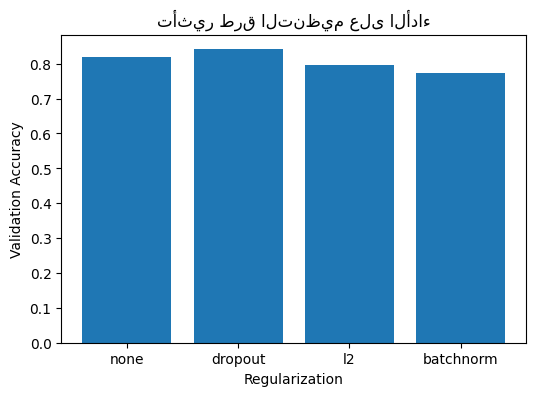

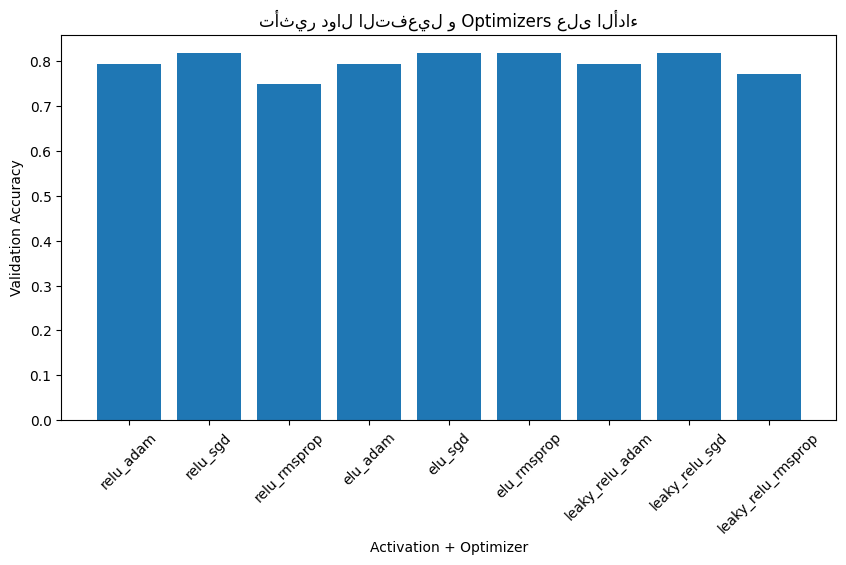

   Batch Size  Validation Accuracy
0          16             0.772727
1          32             0.840909
2          64             0.818182
3         128             0.840909
  Regularization  Validation Accuracy
0           none             0.818182
1        dropout             0.840909
2             l2             0.795455
3      batchnorm             0.772727
  Activation_Optimizer  Validation Accuracy
0            relu_adam             0.795455
1             relu_sgd             0.818182
2         relu_rmsprop             0.750000
3             elu_adam             0.795455
4              elu_sgd             0.818182
5          elu_rmsprop             0.818182
6      leaky_relu_adam             0.795455
7       leaky_relu_sgd             0.818182
8   leaky_relu_rmsprop             0.772727
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Test Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1  

In [15]:
# =====================================================
# 03_hyperparameter_tuning.ipynb (تحديث)
# =====================================================

# ----------------------
# 1️⃣ استيراد المكتبات
# ----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt

# ----------------------
# 2️⃣ تحميل البيانات
# ----------------------
data = pd.read_csv('/content/dataset/Heart_Disease_Prediction.csv')

# ترميز الهدف
data['Heart Disease'] = data['Heart Disease'].apply(lambda x: 1 if x=='Presence' else 0)

# تقسيم المميزات والهدف
X = data.drop('Heart Disease', axis=1)
y = data['Heart Disease']

# تقسيم Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ----------------------
# 3️⃣ دالة بناء النموذج للـ Keras Tuner
# ----------------------
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # عدد الطبقات المخفية من 2 إلى 5
    for i in range(hp.Int('num_layers', 2, 5)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            activation=hp.Choice(f'activation_{i}', ['relu', 'elu', 'leaky_relu'])
        ))
        model.add(layers.Dropout(hp.Choice(f'dropout_{i}', [0.0, 0.2, 0.3, 0.5])))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ----------------------
# 4️⃣ تشغيل Keras Tuner
# ----------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='heart_disease_fcnn'
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("أفضل معاملات Hyperparameters:", best_hps.values)

# ----------------------
# 5️⃣ تجربة Batch Size مختلفة
# ----------------------
batch_sizes = [16, 32, 64, 128]
batch_results = {}

for bs in batch_sizes:
    model = build_model(best_hps)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=bs,
        verbose=0
    )
    val_acc = history.history['val_accuracy'][-1]
    batch_results[bs] = val_acc

# ----------------------
# 6️⃣ تجربة Regularization مختلفة
# ----------------------
regularizations = ['none', 'dropout', 'l2', 'batchnorm']
reg_results = {}

for reg in regularizations:
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01) if reg=='l2' else None))

    if reg=='batchnorm':
        model.add(layers.BatchNormalization())
    if reg=='dropout':
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    reg_results[reg] = val_acc

# ----------------------
# 7️⃣ تجربة Activation Functions و Optimizers
# ----------------------
activations = ['relu', 'elu', 'leaky_relu']
optimizers = ['adam', 'sgd', 'rmsprop']
act_opt_results = {}

for act in activations:
    for opt in optimizers:
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        model.add(layers.Dense(64, activation=act))
        model.add(layers.Dense(32, activation=act))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, verbose=0)
        val_acc = history.history['val_accuracy'][-1]
        act_opt_results[f'{act}_{opt}'] = val_acc

# ----------------------
# 8️⃣ عرض النتائج بصريًا
# ----------------------

# Batch Size
plt.figure(figsize=(6,4))
plt.bar(batch_results.keys(), batch_results.values())
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('تأثير حجم الدُفعة على الأداء')
plt.show()

# Regularization
plt.figure(figsize=(6,4))
plt.bar(reg_results.keys(), reg_results.values())
plt.xlabel('Regularization')
plt.ylabel('Validation Accuracy')
plt.title('تأثير طرق التنظيم على الأداء')
plt.show()

# Activation + Optimizer
plt.figure(figsize=(10,5))
plt.bar(act_opt_results.keys(), act_opt_results.values())
plt.xticks(rotation=45)
plt.xlabel('Activation + Optimizer')
plt.ylabel('Validation Accuracy')
plt.title('تأثير دوال التفعيل و Optimizers على الأداء')
plt.show()

# ----------------------
# 9️⃣ إنشاء جداول مقارنة
# ----------------------
results_df = pd.DataFrame({
    'Batch Size': list(batch_results.keys()),
    'Validation Accuracy': list(batch_results.values())
})
reg_df = pd.DataFrame({
    'Regularization': list(reg_results.keys()),
    'Validation Accuracy': list(reg_results.values())
})
act_opt_df = pd.DataFrame({
    'Activation_Optimizer': list(act_opt_results.keys()),
    'Validation Accuracy': list(act_opt_results.values())
})

print(results_df)
print(reg_df)
print(act_opt_df)

# حفظ الجداول
results_df.to_csv('batch_size_results.csv', index=False)
reg_df.to_csv('regularization_results.csv', index=False)
act_opt_df.to_csv('activation_optimizer_results.csv', index=False)

# ----------------------
# 🔟 تقييم النموذج الأفضل على Test Set
# ----------------------
y_pred = (best_model.predict(X_test) > 0.5).astype('int32')
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
